Mapping particle tracks from Ocean Parcels unto the Salish Sea Atlantis Boxes. 
Original code written by Bec Gordon & Javier Porobic, CSIRO.
Link to the [SSAM Ocean Parcels Repo](https://bitbucket.csiro.au/users/por07g/repos/ssam_oceanparcels/browse)

In [33]:
import os
import sys
import xarray as xr
import numpy as np
import geopandas as gpd
import pandas as pd
from netCDF4 import Dataset
from shapely.geometry import Point
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
sys.path.append('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/')
import ssam_groups as groups

In [26]:
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(shapefile_name)
data_df = data_df.sort_values(by=['BOX_ID'])
box_depth = data_df['BOTZ']
box_area = data_df['AREA']
box_volume = box_area * box_depth
surface_volume = box_area * 25
num_boxes = data_df.shape[0]
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]

#print(box_volume)

In [4]:
# Ocean Parcels Spill File
inputFileName = '5b_TurnPoint_Dilbit_2019-01-14_OP_D50_wp3.nc'
num_particles = 100

In [5]:
scenario = inputFileName.split(sep = '_')

In [6]:
# Oil type properties & spill location selection

Dilbit = {
    "Density": 1011.2, #kg/m^3
    "Naphthalene": 24, #mg/kg oil
    "Phenanthrene": 17,
    "Pyrene": 10,
    "Benzo": 3,
}

BunkerC = {
    "Density": 995.3,
    "Naphthalene": 680,
    "Phenanthrene": 796,
    "Pyrene": 266,
    "Benzo": 56,
}

Diesel = {
    "Density": 831.0,
    "Naphthalene": 3664,
    "Phenanthrene": 1000,
    "Pyrene": 0.000,
    "Benzo": 0.000,
}

Crude = {
    "Density": 884.7,
    "Naphthalene": 654,
    "Phenanthrene": 327,
    "Pyrene": 13,
    "Benzo": 2,
}

fuel_type = {
    "Dilbit" : Dilbit,
    "BunkerC" : BunkerC,
    "Diesel" : Diesel,
    "Crude" : Crude,
}

spill_volume = {
    "5b" : 2000, #m^3 
    "6a" : 15,
    "7a" : 1000,
    "4a" : 500,
}

spill_box_surface_volume = {
    "5b" : (322271112.331102*25), #m^3 
    "6a" : 15,
    "7a" : 1000,
    "4a" : 500,
}

In [7]:
# Calculations of oil mass in mg
oil_mass_kg = (fuel_type[scenario[2]]["Density"] * spill_volume[scenario[0]])
naph_mass_mg = oil_mass_kg * fuel_type[scenario[2]]["Naphthalene"]
phen_mass_mg = oil_mass_kg * fuel_type[scenario[2]]["Phenanthrene"]
pyrene_mass_mg = oil_mass_kg * fuel_type[scenario[2]]["Pyrene"]
benzo_mass_mg = oil_mass_kg * fuel_type[scenario[2]]["Benzo"]
oil_mass_mg = oil_mass_kg * 1e6

print(str(scenario[2])+' spill mass of '+str(oil_mass_mg)+' in mg')
print('Naphthalene spill mass of '+str(naph_mass_mg)+' in mg')
print('Phenanthrene spill mass of '+str(phen_mass_mg)+' in mg')
print('Pyrene spill mass of '+str(pyrene_mass_mg)+' in mg')
print('Benzo spill mass of '+str(benzo_mass_mg)+' in mg')

Dilbit spill mass of 2022400000000.0 in mg
Naphthalene spill mass of 48537600.0 in mg
Phenanthrene spill mass of 34380800.0 in mg
Pyrene spill mass of 20224000.0 in mg
Benzo spill mass of 6067200.0 in mg


In [8]:
# Calculations of oil per particle in mg/m^3/particle
release_start = scenario[3]
oil_per_particle = (fuel_type[scenario[2]]["Density"] * spill_volume[scenario[0]]) / num_particles
naph_per_particle = oil_per_particle * fuel_type[scenario[2]]["Naphthalene"] / spill_box_surface_volume[scenario[0]]
phen_per_particle = oil_per_particle * fuel_type[scenario[2]]["Phenanthrene"] / spill_box_surface_volume[scenario[0]]
pyrene_per_particle = oil_per_particle * fuel_type[scenario[2]]["Pyrene"] / spill_box_surface_volume[scenario[0]]
benzo_per_particle = oil_per_particle * fuel_type[scenario[2]]["Benzo"] / spill_box_surface_volume[scenario[0]]
release_start_time = np.datetime64(release_start)

In [9]:
mgoil_per_particle = oil_per_particle * 1e6 / spill_box_surface_volume[scenario[0]]

In [10]:
# Calculating the surface concentration of each contaminant for the entire spill
oil_full = oil_per_particle * num_particles * 1e6 / spill_box_surface_volume[scenario[0]]
naph_full = naph_per_particle * num_particles
phen_full = phen_per_particle * num_particles
pyrene_full = pyrene_per_particle * num_particles
benzo_full = benzo_per_particle * num_particles

print(str(scenario[2])+' spill concentration of '+str(oil_full)+' in mg/m^3')
print('Naphthalene spill concentration of '+str(naph_full)+' in mg/m^3')
print('Phenanthrene spill concentration of '+str(phen_full)+' in mg/m^3')
print('Pyrene spill concentration of '+str(pyrene_full)+' in mg/m^3')
print('Benzo spill concentration of '+str(benzo_full)+' in mg/m^3')

Dilbit spill concentration of 251.01846521349788 in mg/m^3
Naphthalene spill concentration of 0.006024443165123949 in mg/m^3
Phenanthrene spill concentration of 0.004267313908629463 in mg/m^3
Pyrene spill concentration of 0.0025101846521349788 in mg/m^3
Benzo spill concentration of 0.0007530553956404937 in mg/m^3


In [11]:
output_file_path = '/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/Test_Scenario_5b_4/outputSalishSea.nc'
output = xr.open_dataset(str(output_file_path), decode_cf=True)

In [12]:
time = np.ma.filled(output.variables['t'], np.nan)
end = time.size-1

In [23]:
def calculate_pah_end_mass(pah, scenario):

    masses = np.zeros((num_boxes))

    pelagic_oiled = np.ma.filled(scenario.variables[pah][end,:,0:6], np.nan) # tonnes
    pelagic_oiled = pelagic_oiled.sum(axis=1)

    for box in range(0, num_boxes):
        pelagic_mass = pelagic_oiled[box] * box_volume[box]
        masses[box] = pelagic_mass
    
    pah_end_mass = masses.sum(axis=0)
    print(pah_end_mass)



In [25]:
for pah in groups.pahs:
    print(pah)
    calculate_pah_end_mass(pah, output)

Phenanthrene
3.5546781909419335e-20
Naphthalene
4.813488701094962e-308
Pyrene
0.08850971461414296
Benzo
0.03798233245346352


In [54]:
for pah in groups.pahs:
    masses = np.zeros((num_boxes))

    pelagic_oiled = np.ma.filled(output.variables[pah][end,:,0:6], np.nan) # tonnes
    pelagic_oiled = pelagic_oiled.sum(axis=1)

    for box in range(0, num_boxes):
        pelagic_mass = pelagic_oiled[box] * box_volume[box]
        print((box, box_volume[box]))
        masses[box] = pelagic_mass    
        pah_end_mass = masses.sum(axis=0)

    data_df[str(pah)] = masses

(0, 0)
(1, 0)
(2, 0)
(3, 0)
(4, 11621464000)
(5, 8518712600)
(6, 0)
(7, 0)
(8, 9590117800)
(9, 23230788400)
(10, 0)
(11, 0)
(12, 0)
(13, 4504040000)
(14, 0)
(15, 16123736200)
(16, 0)
(17, 0)
(18, 6102427200)
(19, 10260885650)
(20, 28806085900)
(21, 18201151600)
(22, 1567899700)
(23, 48560105500)
(24, 0)
(25, 13321680900)
(26, 0)
(27, 2295666800)
(28, 0)
(29, 0)
(30, 4328329700)
(31, 0)
(32, 0)
(33, 13888569800)
(34, 6430026350)
(35, 16252262100)
(36, 44632891600)
(37, 0)
(38, 0)
(39, 0)
(40, 0)
(41, 0)
(42, 0)
(43, 0)
(44, 0)
(45, 19852411450)
(46, 13090433250)
(47, 32778798650)
(48, 68270242000)
(49, 0)
(50, 13053473700)
(51, 0)
(52, 0)
(53, 15114991100)
(54, 11799687400)
(55, 14394886100)
(56, 8534988000)
(57, 0)
(58, 13735991200)
(59, 28955574900)
(60, 0)
(61, 5025412500)
(62, 2838267750)
(63, 5425020400)
(64, 59614154100)
(65, 93271610000)
(66, 62936234750)
(67, 34094627100)
(68, 16864753000)
(69, 5559376750)
(70, 6372685750)
(71, 6897461075)
(72, 8987216850)
(73, 53304925500)
(74,

<Figure size 432x288 with 0 Axes>

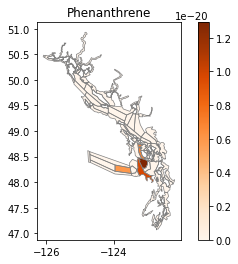

<Figure size 432x288 with 0 Axes>

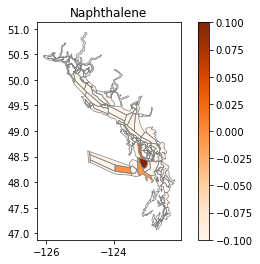

<Figure size 432x288 with 0 Axes>

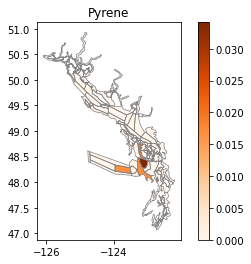

<Figure size 432x288 with 0 Axes>

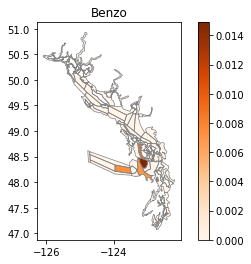

In [46]:
for pah in groups.pahs:
    data_df.loc[land_boxes, pah] = 0

    _cmap = cm.Oranges
    
    ax = plt.figure()
    

    ax = data_df.plot(column = pah, cmap=_cmap,
        legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
        )
    ax.set_title((str(pah)), fontsize = 12)
    data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
    land_df.plot(ax=ax, color='white')

In [50]:
data_df

,cat,BOUNDARY,BOTZ,BOX_ID,Region,Sub_Basins,PSmodel,vertmix,horizmix,PERIMETER,list,AREA,DisplayDep,geometry,Phenanthrene,Naphthalene,Pyrene,Benzo
118,119,1,400,0,Boundary,Main Basin,No,0.0,1.0,57419.0,NaN,97362056,-1.0,"POLYGON ((-124.71244 48.59717, -124.70793 48.5...",0.000000e+00,0.000000e+00,0.000000,0.000000
47,48,0,50,1,Juan de Fuca,Main Basin,No,0.0,1.0,19721.0,1.0,655575973,50.0,"POLYGON ((-124.71244 48.59717, -123.52445 48.3...",0.000000e+00,0.000000e+00,0.000000,0.000000
48,49,0,100,2,Juan de Fuca,Main Basin,No,0.0,1.0,14480.0,2.0,682702420,100.0,"POLYGON ((-124.70793 48.54075, -123.96270 48.3...",0.000000e+00,0.000000e+00,0.000000,0.000000
119,120,0,100,3,Juan de Fuca,Main Basin,No,0.0,1.0,20347.0,NaN,494069246,100.0,"POLYGON ((-124.69970 48.43773, -123.96270 48.2...",0.000000e+00,0.000000e+00,0.000000,0.000000
36,37,0,100,4,Juan de Fuca,Main Basin,No,0.0,1.0,96558.0,4.0,446328916,100.0,"POLYGON ((-123.51285 48.28257, -123.47959 48.1...",5.984474e-21,9.025884e-309,0.016966,0.007392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,114,0,0,125,Island,Johnson strait island,No,0.0,1.0,46792.0,NaN,60940418,0.0,"POLYGON ((-125.12770 50.12882, -125.14511 50.1...",0.000000e+00,0.000000e+00,0.000000,0.000000
114,115,0,0,126,Island,Johnson strait island,No,0.0,1.0,69501.0,NaN,144127317,0.0,"POLYGON ((-124.92793 50.18117, -124.89472 50.1...",0.000000e+00,0.000000e+00,0.000000,0.000000
115,116,0,0,127,Island,Johnson strait island,No,0.0,1.0,11185.0,NaN,305171650,0.0,"POLYGON ((-124.97876 50.25572, -124.95843 50.2...",0.000000e+00,0.000000e+00,0.000000,0.000000
110,111,0,0,128,Island,Johnson strait island,No,0.0,1.0,50504.0,NaN,110721857,0.0,"POLYGON ((-125.39146 50.36217, -125.42837 50.3...",0.000000e+00,0.000000e+00,0.000000,0.000000
